In [33]:
import cv2
import numpy as np
import os 
import time

from IPython.display import clear_output
from PIL import Image, ImageDraw

# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import crossMask, checkImageType, circularMask, lightCorrectionDiff, rectMask, mergeMasks

from pepe.analysis import initialForceSolve, forceOptimize
from pepe.tracking import houghCircle, convCircle
from pepe.simulate import genSyntheticResponse

import progressbar

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

rootFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/'
dataFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/2022-02-02_Wide/'

In [48]:
# Our radius that we will be identifying particles with
guessRadius = 160

# A particle is about 1cm across
pxPerMeter = 2*guessRadius / .01
# No idea what the actual value for this is
fSigma = 140

# How much to blur the photoelastic channel by
blurKernel = 2

# Parameters of our force solving method
contactPadding = 20
g2MaskPadding = 2
contactMaskRadius = 40
brightfield = False

# Create a mask over the image, that will also be used to detect the boundary
maskXBounds = [430, 760] # Found manually
maskYBounds = [340, 670] # Found manually

maskArr = crossMask(image.shape, xlim=np.array(maskXBounds), ylim=np.array(maskYBounds))

# Add in the pegs on the boundary particles
pegCenters = [[20, 550], [20, 650], [990, 540], [990, 650]]
pegRadii = 15

for i in range(len(pegCenters)):
    maskArr = maskArr - circularMask(image.shape, np.array(pegCenters[i]), pegRadii)
    
maskArr = maskArr > 0

# Account for any light gradients in the image
correctionImage = checkImageType(rootFolder + '2022-02-02_Calibration.bmp')
# For light correction, we want two separate images, one vertical and one horizontal
height, width = correctionImage.shape[:2]
verticalMask = np.array([[int(i < maskXBounds[1] and i > maskXBounds[0]) for i in range(width)] for j in range(height)])
horizontalMask = np.transpose([[int(i < maskYBounds[1] and i > maskYBounds[0]) for i in range(height)] for j in range(width)])

correction = lightCorrectionDiff(correctionImage, verticalMask, horizontalMask)

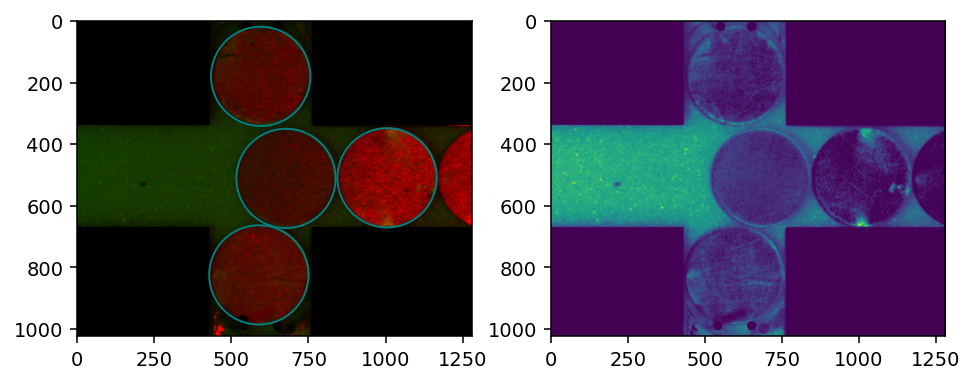

In [49]:
# Make some fake data with several potential wall contacts
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

#image = checkImageType('test_data/Test_2022-01-28.bmp')
image = checkImageType(dataFolder + 'frame0001.bmp')

# g2 to force conversion is calibrated on the scale [0, 1], not [0, 255]
# We also blur the images a little, since they are visibly grainy
photoelasticChannel = cv2.blur(image[:,:,1].astype(np.float64) / 255, (3,3))

centers, radii = convCircle(image[:,:,0] * maskArr[:,:,0], guessRadius)

centers = centers.astype(np.int64)
radii = radii.astype(np.int64)
# Make them all odd
radii += (radii % 2) == 0

ax[0].imshow(maskArr * image)
for i in range(len(centers)):
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particles', color='teal', fill=False, linewidth=1)
    ax[0].add_artist(c)

ax[1].imshow(photoelasticChannel * maskArr[:,:,0])
plt.show()

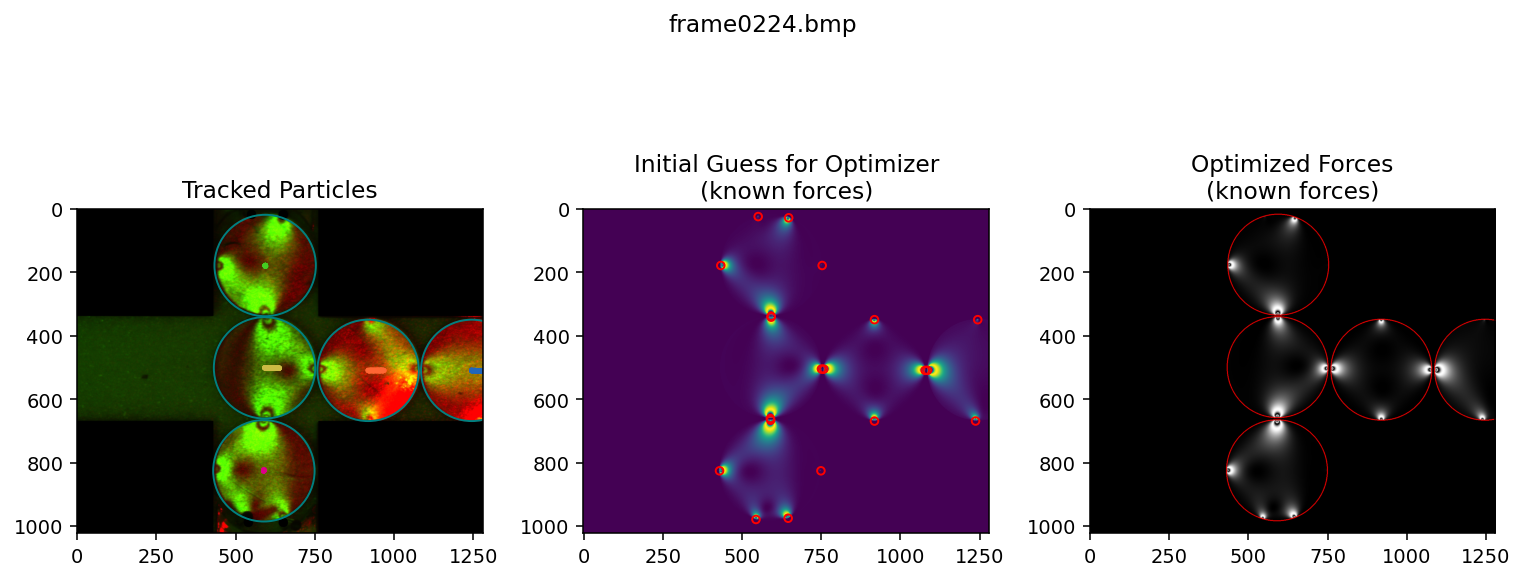

 39% (128 of 325) |########              | Elapsed Time: 0:41:33 ETA:   1:14:51

forceOptimize() got an unexpected keyword argument 'betaTolerance'


In [ ]:
imageFiles = os.listdir(dataFolder)
imageFiles = np.sort(imageFiles)

centerColors = ['#FF6633', # Orange
                '#CCBB44', # Yellow
                '#DD0088', # Pink
                '#44CC22', # Green
                '#2266BB'] # Blue

centersArr = []
radiiArr = []

forceArr = []
betaArr = []
alphaArr = []

detectionTime = []
guessGenerationTime = []
optimizeTime = []
plotTime = []

# Only grab bitmap files
imageFiles = [i for i in imageFiles if i[-3:] == 'bmp']
imageFiles = imageFiles[95:]

bar = progressbar.ProgressBar(max_value=len(imageFiles))

for i in range(len(imageFiles)):
    image = checkImageType(dataFolder + imageFiles[i])
    photoelasticChannel = cv2.blur((image[:,:,1] + correction).astype(np.float64) / 255, (blurKernel,blurKernel))
    
    # ----------------
    # Detect particles
    # ----------------
    start = time.perf_counter()
    centers, radii = convCircle(image[:,:,0] * maskArr[:,:,0], guessRadius)
    
    centers = centers.astype(np.int64)
    radii = radii.astype(np.int64)
    
    # We want to make sure particles have unique identifiers, so we
    # keep the order the same across detections (by finding the closest
    # particle in the previous step)
    if i != 0:
        orderedCenters = []
        addedIndices = []
        for j in range(len(centersArr[-1])):
            distances = np.zeros(len(centers))
            for k in range(len(centers)):
                distances[k] = (centersArr[-1][j][0] - centers[k][0])**2 + (centersArr[-1][j][1] - centers[k][1])**2
            closestIndex = np.argsort(distances)
            closestIndex = [k for k in closestIndex if k not in addedIndices]
            if len(closestIndex) > 0:
                orderedCenters.append(centers[closestIndex[0]])
                addedIndices.append(closestIndex[0])

        # And add any new ones
        for j in range(len(centers)):
            if j not in addedIndices:
                orderedCenters.append(centers[j])

        centers = orderedCenters
    detectionTime.append(time.perf_counter() - start)

    # ----------------------
    # Generate initial guess
    # ----------------------
    start = time.perf_counter()
    if i == 0 or len(centers) != len(centersArr[-1]):
        forceGuessArr, alphaGuessArr, betaGuessArr = initialForceSolve(photoelasticChannel,
                                                    centers, radii, fSigma, pxPerMeter,
                                                    contactPadding, g2MaskPadding,
                                                    contactMaskRadius=contactMaskRadius,
                                                    boundaryMask=maskArr, ignoreBoundary=False)
    else:
        forceGuessArr = forceArr[-1]
        alphaGuessArr = alphaArr[-1]
        betaGuessArr = betaArr[-1]
        # In this case, we want to add a small randomly generated contribution
        # so that the algorithm doesn't get stuck in some incorrect loop
        #for j in range(len(centers)):
        #    forceGuessArr[i] = [np.abs(f + np.random.normal(0, .03)) for f in forceGuessArr]

    # Force estimation is garbage because of noise, so just use a flat value
    #forceGuessArr = np.zeros(len(forceGuessArr)) + .1

    #print(forceGuessArr)
    #print(alphaGuessArr)
    #print(betaGuessArr)
    guessGenerationTime.append(time.perf_counter() - start)

    # -------------------------------
    # Optimize each particle's forces
    # -------------------------------
    start = time.perf_counter()
    optimizedForceArr = []
    optimizedBetaArr = []
    optimizedAlphaArr = []
    failed = [False for i in range(len(centers))]

    for j in range(len(centers)):
        try:
            optForceArr, optBetaArr, optAlphaArr, res = forceOptimize(forceGuessArr[j], betaGuessArr[j], alphaGuessArr[j], radii[j], centers[j], photoelasticChannel,
                                                                      fSigma, pxPerMeter, brightfield, maxEvals=[50, 5, 5], method='nelder',
                                                                      parametersToFit=[['f', 'a'], ['b'], ['a']], allowRemoveForces=False, betaTolerance=.1)
            optimizedForceArr.append(optForceArr)
            optimizedBetaArr.append(optBetaArr)
            optimizedAlphaArr.append(optAlphaArr)
        except Exception as ex:
            print(ex)
            failed[j] = True
            optimizedForceArr, optimizedAlphaArr, optimizedBetaArr = initialForceSolve(photoelasticChannel,
                                                        centers, radii, fSigma, pxPerMeter,
                                                        contactPadding, g2MaskPadding,
                                                        contactMaskRadius=contactMaskRadius,
                                                        boundaryMask=maskArr, ignoreBoundary=False)
            
    optimizeTime.append(time.perf_counter() - start)
    
    forceArr.append(optimizedForceArr)
    betaArr.append(optimizedBetaArr)
    alphaArr.append(optimizedAlphaArr)
    centersArr.append(centers)
    radiiArr.append(radii)
    
    # -----------
    # Plot things
    # -----------
    start = time.perf_counter()  
    estimatedPhotoelasticChannel = np.zeros_like(photoelasticChannel, dtype=np.float64)    
    for j in range(len(centers)):
        estimatedPhotoelasticChannel += genSyntheticResponse(np.array(forceGuessArr[j]),
                                                             np.array(alphaGuessArr[j]),
                                                             np.array(betaGuessArr[j]),
                                                             fSigma, radii[j],
                                                             pxPerMeter, brightfield, imageSize=photoelasticChannel.shape,
                                                             center=centers[j])
    
    

    optimizedPhotoelasticChannel = np.zeros(photoelasticChannel.shape)
    for j in range(len(centers)):
        optimizedPhotoelasticChannel += genSyntheticResponse(np.array(optimizedForceArr[j]),
                                                             np.array(optimizedAlphaArr[j]),
                                                             np.array(optimizedBetaArr[j]),
                                                             fSigma, radii[j], pxPerMeter, brightfield,
                                                             imageSize=photoelasticChannel.shape, center=centers[j])
    
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(11,5))
    
    ax[0].imshow(maskArr * image)
    ax[0].set_title('Tracked Particles')
    for j in range(len(centers)):
        c = plt.Circle(centers[j][::-1], radii[j], label='Detected particles', color='teal', fill=False, linewidth=1)
        ax[0].add_artist(c)
        # Now add contacts
        for k in range(len(betaGuessArr[j])):
            contactPoint = centers[j] + radii[j] * np.array([np.cos(betaGuessArr[j][k]), np.sin(betaGuessArr[j][k])])
            #linePoints = np.array([centers[i], radii[i] * np.array([np.cos(betaGuessArr[i][j]), np.sin(betaGuessArr[i][j])])])
            #plt.plot(linePoints[0], linePoints[1], color='blue')
            cc = plt.Circle(contactPoint[::-1], 12, color='red', fill=False, linewidth=1)
            ax[1].add_artist(cc)
            
        # Now plot past center positions
        for k in range(len(centersArr)):
            if len(centersArr[k]) >= j:
                cc = plt.Circle(centersArr[k][j][::-1], 5, color=centerColors[j], fill=True)
                ax[0].add_artist(cc)
            

    ax[1].imshow(estimatedPhotoelasticChannel)
    ax[1].set_title('Initial Guess for Optimizer\n(known forces)')
    
    imgArr = np.zeros((*optimizedPhotoelasticChannel.shape, 3))
    #for j in range(3):
    #    imgArr[:,:,j] = optimizedPhotoelasticChannel*255
    
    img = Image.fromarray(optimizedPhotoelasticChannel*255)
    img = img.convert('RGB')
    drawObj = ImageDraw.Draw(img)
    for j in range(len(centers)):
        leftUpPoint = (centers[j][1]-radii[j], centers[j][0]-radii[j])
        rightDownPoint = (centers[j][1]+radii[j], centers[j][0]+radii[j])
        twoPointList = [leftUpPoint, rightDownPoint]
        color =  '#FF0000' if failed[j] else '#00AAAA'
        drawObj.ellipse(twoPointList, outline=color, fill=None, width=3)
    
    ax[2].imshow(img)
    ax[2].set_title('Optimized Forces\n(known forces)')
    
    fig.suptitle(imageFiles[i])
    fig.tight_layout()
    plt.show()
    plotTime.append(time.perf_counter() - start)

    img.save('/run/media/jack/Seagate Portable Drive/Research/SpaceJam/2022-02-02_Wide_Synthetic_3/' + imageFiles[i][:-3] + 'png')    
    bar.update(i)

In [21]:
print(np.mean(detectionTime))
print(np.mean(guessGenerationTime))
print(np.mean(optimizeTime))
print(np.mean(plotTime))

0.6551790300949837
2.949671449440476
8.326839840290763
1.2041823356229129


[ 1.54958739 -0.15101534 -3.0088377 ]


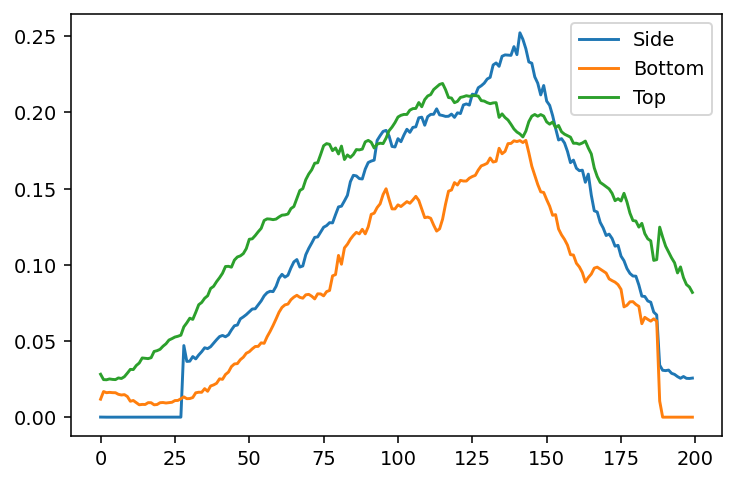

In [61]:
centerParticleIndex = 1
print(betaArr[0][centerParticleIndex])

labels = ['Side', 'Bottom', 'Top']

for i in range(len(forceArr[0][centerParticleIndex])):
    singleForce = [forceArr[j][centerParticleIndex][i] for j in range(len(forceArr))]
    plt.plot(singleForce, label=labels[i])

plt.legend()
plt.show()